In [71]:
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
import librosa.display
from tqdm import tqdm
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split


Processing sound categories: 100%|██████████| 7/7 [01:37<00:00, 13.87s/it]


X_data shape: (13842, 128, 52)
Y_data shape: (13842,)
First 10 labels in Y_data: ['cough' 'cough' 'cough' 'cough' 'cough' 'cough' 'cough' 'cough' 'cough'
 'cough']


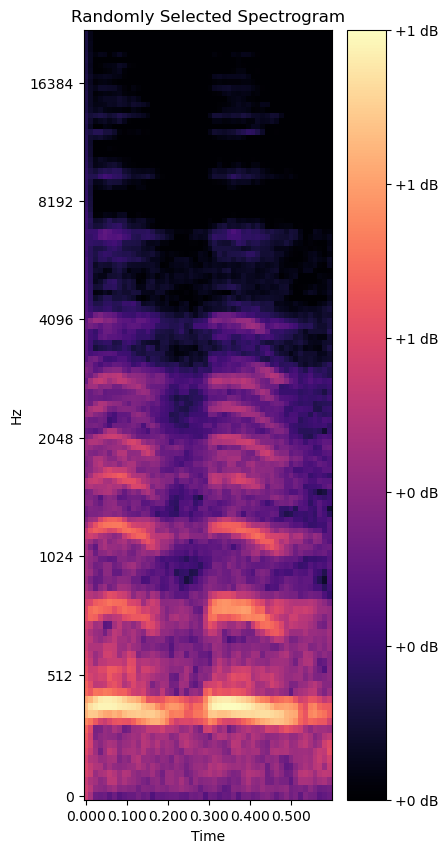

Selected Y label: crying


In [72]:
# 루트 디렉토리 경로
root_directory = '/Users/jaeyoung/creamo/ClapNet/data/174.자연 및 인공적 발생 非언어적 소리 데이터/01.데이터/1.Training/원천데이터/TS_3.사람'

# 처리할 소리 데이터와 라벨
sound_labels = {
    '1.생리현상/1.기침': 'cough',
    # '1.생리현상/2.트림': 'burp',
    # '1.생리현상/3.방귀': 'fart',
    '1.생리현상/4.재채기': 'sneeze',
    '2.신체를 이용한 인위적 소리/1.박수': 'clap',
    # '2.신체를 이용한 인위적 소리/3.휘파람': 'whistle',
    '3.감정/1.웃음': 'laughter',
    '3.감정/2.울음': 'crying',
    '3.감정/3.비명': 'scream',
    # '4.이동감지/1.실외에서 걸으면서 이동하는 소리': 'walking_outdoor',
    '4.이동감지/2.밟는소리': 'footstep',
    # '4.이동감지/3.실외에서 뛰면서 이동하는 소리': 'running_outdoor',
}

# 윈도우 크기 및 기타 설정
window_duration = 0.6  # 초
hop_length = 512  # 기본 hop length
window_size = None
minimum_distance = None
sr = None  # 샘플링 레이트

# 데이터 저장용 리스트 초기화
X_data = []
Y_data = []

def process_audio_files(directory, label):
    global window_size, sr, minimum_distance
    file_paths = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith('.mp3'):
                file_paths.append(os.path.join(root, file))

    for file_path in tqdm(file_paths, desc=f'Processing {label} files'):
        y, sr = librosa.load(file_path, sr=None)
        start_time = 8
        start_sample = int(start_time * sr)
        y_trimmed = y[start_sample:]
        y_trimmed_db = librosa.amplitude_to_db(np.abs(y_trimmed), ref=np.max)
        threshold_db = -20
        indices = np.where(y_trimmed_db > threshold_db)[0]

        if window_size is None:
            window_size = int(window_duration * sr)
            minimum_distance = int(0.6 * sr)

        last_index = -minimum_distance

        for i, idx in enumerate(indices):
            if idx - last_index >= minimum_distance:
                start_idx = max(0, idx - window_size // 2)
                end_idx = min(len(y_trimmed), idx + window_size // 2)
                y_window = y_trimmed[start_idx:end_idx]
                S_window = librosa.feature.melspectrogram(y=y_window, sr=sr, n_mels=128, hop_length=hop_length)
                S_window_dB = librosa.power_to_db(S_window, ref=np.max)
                S_window_dB_normalized = (S_window_dB - np.min(S_window_dB)) / (np.max(S_window_dB) - np.min(S_window_dB))

                # 스펙트로그램의 크기를 확인하고 패딩 적용
                target_width = (window_size // hop_length) + 1
                if S_window_dB_normalized.shape[1] < target_width:
                    padding = target_width - S_window_dB_normalized.shape[1]
                    S_window_dB_normalized = np.pad(S_window_dB_normalized, ((0, 0), (0, padding)), mode='constant')

                X_data.append(S_window_dB_normalized)
                Y_data.append(label)
                last_index = idx

# 모든 소리 데이터를 처리
for subdir, label in tqdm(sound_labels.items(), desc='Processing sound categories'):
    directory = os.path.join(root_directory, subdir)
    process_audio_files(directory, label)

# numpy 배열로 변환
X_data = np.array(X_data)
Y_data = np.array(Y_data)

# 데이터 저장
np.save('X_train.npy', X_data)
np.save('Y_train.npy', Y_data)

# 데이터 크기 확인
print(f'X_data shape: {X_data.shape}')
print(f'Y_data shape: {Y_data.shape}')

# Y_data의 처음 10개 값 출력
print('First 10 labels in Y_data:', Y_data[:10])

# 무작위로 1개의 스펙트로그램 선택 및 시각화
import random
random_idx = random.choice(range(X_data.shape[0]))

# 시각화
fig, ax = plt.subplots(figsize=(4, 10))  # 세로로 긴 형태로 설정
img = librosa.display.specshow(X_data[random_idx], sr=sr, x_axis='time', y_axis='mel', ax=ax)
cbar = fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Randomly Selected Spectrogram')

# 이미지를 저장합니다 (선택 사항)
plt.savefig('random_spectrogram_long.png', bbox_inches='tight', pad_inches=0)
plt.show()

# 해당 Y 라벨 프린트
print('Selected Y label:', Y_data[random_idx])


Processing sound categories: 100%|██████████| 7/7 [00:14<00:00,  2.01s/it]


X_data shape: (2147, 128, 52)
Y_data shape: (2147,)
First 10 labels in Y_data: ['cough' 'cough' 'cough' 'cough' 'cough' 'cough' 'cough' 'cough' 'cough'
 'cough']


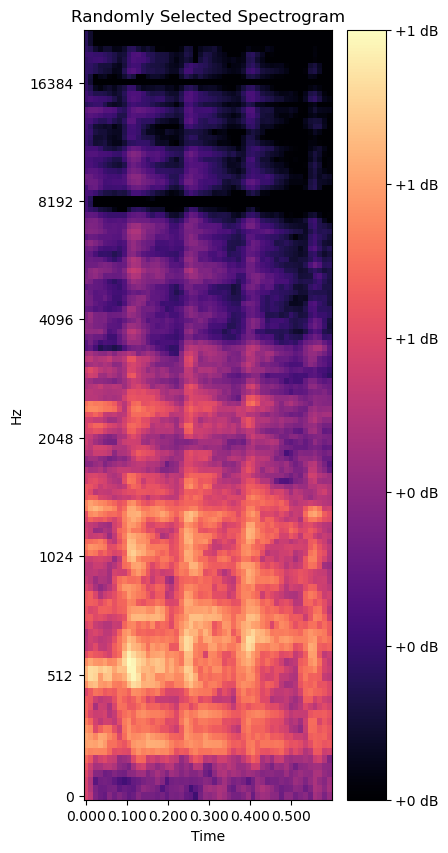

Selected Y label: laughter


In [73]:
import os
import numpy as np
import librosa
import matplotlib.pyplot as plt
from tqdm import tqdm

# 루트 디렉토리 경로
root_directory = '/Users/jaeyoung/creamo/ClapNet/data/174.자연 및 인공적 발생 非언어적 소리 데이터/01.데이터/2.Validation/원천데이터/VS_3.사람'

# 처리할 소리 데이터와 라벨
sound_labels = {
    '1.생리현상/1.기침': 'cough',
    # '1.생리현상/2.트림': 'burp',
    # '1.생리현상/3.방귀': 'fart',
    '1.생리현상/4.재채기': 'sneeze',
    '2.신체를 이용한 인위적 소리/1.박수': 'clap',
    # '2.신체를 이용한 인위적 소리/3.휘파람': 'whistle',
    '3.감정/1.웃음': 'laughter',
    '3.감정/2.울음': 'crying',
    '3.감정/3.비명': 'scream',
    # '4.이동감지/1.실외에서 걸으면서 이동하는 소리': 'walking_outdoor',
    '4.이동감지/2.밟는소리': 'footstep',
    # '4.이동감지/3.실외에서 뛰면서 이동하는 소리': 'running_outdoor',
}

# 윈도우 크기 및 기타 설정
window_duration = 0.6  # 초
hop_length = 512  # 기본 hop length
window_size = None
minimum_distance = None
sr = None  # 샘플링 레이트

# 데이터 저장용 리스트 초기화
X_data = []
Y_data = []

def process_audio_files(directory, label):
    global window_size, sr, minimum_distance
    file_paths = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith('.mp3'):
                file_paths.append(os.path.join(root, file))

    for file_path in tqdm(file_paths, desc=f'Processing {label} files'):
        y, sr = librosa.load(file_path, sr=None)
        start_time = 8
        start_sample = int(start_time * sr)
        y_trimmed = y[start_sample:]
        y_trimmed_db = librosa.amplitude_to_db(np.abs(y_trimmed), ref=np.max)
        threshold_db = -20
        indices = np.where(y_trimmed_db > threshold_db)[0]

        if window_size is None:
            window_size = int(window_duration * sr)
            minimum_distance = int(0.6 * sr)

        last_index = -minimum_distance

        for i, idx in enumerate(indices):
            if idx - last_index >= minimum_distance:
                start_idx = max(0, idx - window_size // 2)
                end_idx = min(len(y_trimmed), idx + window_size // 2)
                y_window = y_trimmed[start_idx:end_idx]
                S_window = librosa.feature.melspectrogram(y=y_window, sr=sr, n_mels=128, hop_length=hop_length)
                S_window_dB = librosa.power_to_db(S_window, ref=np.max)
                S_window_dB_normalized = (S_window_dB - np.min(S_window_dB)) / (np.max(S_window_dB) - np.min(S_window_dB))

                # 스펙트로그램의 크기를 확인하고 패딩 적용
                target_width = (window_size // hop_length) + 1
                if S_window_dB_normalized.shape[1] < target_width:
                    padding = target_width - S_window_dB_normalized.shape[1]
                    S_window_dB_normalized = np.pad(S_window_dB_normalized, ((0, 0), (0, padding)), mode='constant')

                X_data.append(S_window_dB_normalized)
                Y_data.append(label)
                last_index = idx

# 모든 소리 데이터를 처리
for subdir, label in tqdm(sound_labels.items(), desc='Processing sound categories'):
    directory = os.path.join(root_directory, subdir)
    process_audio_files(directory, label)

# numpy 배열로 변환
X_data = np.array(X_data)
Y_data = np.array(Y_data)

# 데이터 저장
np.save('X_test.npy', X_data)
np.save('Y_test.npy', Y_data)

# 데이터 크기 확인
print(f'X_data shape: {X_data.shape}')
print(f'Y_data shape: {Y_data.shape}')

# Y_data의 처음 10개 값 출력
print('First 10 labels in Y_data:', Y_data[:10])

# 무작위로 1개의 스펙트로그램 선택 및 시각화
import random
random_idx = random.choice(range(X_data.shape[0]))

# 시각화
fig, ax = plt.subplots(figsize=(4, 10))  # 세로로 긴 형태로 설정
img = librosa.display.specshow(X_data[random_idx], sr=sr, x_axis='time', y_axis='mel', ax=ax)
cbar = fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Randomly Selected Spectrogram')

# 이미지를 저장합니다 (선택 사항)
plt.savefig('random_spectrogram_long.png', bbox_inches='tight', pad_inches=0)
plt.show()

# 해당 Y 라벨 프린트
print('Selected Y label:', Y_data[random_idx])


In [74]:
# Load the training data
independent = np.load('X_train.npy')
independent = independent.reshape(independent.shape[0], independent.shape[1], independent.shape[2], 1)
dependent = np.load('Y_train.npy')
dependent = pd.get_dummies(dependent).astype(int)

# Load the test data
independent_test = np.load('X_test.npy')
independent_test = independent_test.reshape(independent_test.shape[0], independent_test.shape[1], independent_test.shape[2], 1)
dependent_test = np.load('Y_test.npy')

# Split the test data into validation and test sets
independent_val, independent_test, dependent_val, dependent_test = train_test_split(
    independent_test, dependent_test, test_size=0.5, random_state=42)

# One-hot encode the validation and test labels
dependent_val = pd.get_dummies(dependent_val).astype(int)
dependent_test = pd.get_dummies(dependent_test).astype(int)

# Ensure all categories are included in one-hot encoding for both validation and test sets
dependent_categories = sorted(set(dependent_val.columns).union(set(dependent_test.columns)))
dependent_val = dependent_val.reindex(columns=dependent_categories, fill_value=0)
dependent_test = dependent_test.reindex(columns=dependent_categories, fill_value=0)

In [75]:
# Print shapes to verify
print(f'Training data shape: {independent.shape}, {dependent.shape}')
print(f'Validation data shape: {independent_val.shape}, {dependent_val.shape}')
print(f'Test data shape: {independent_test.shape}, {dependent_test.shape}')

Training data shape: (13842, 128, 52, 1), (13842, 7)
Validation data shape: (1073, 128, 52, 1), (1073, 7)
Test data shape: (1074, 128, 52, 1), (1074, 7)


In [76]:
# Define the model
X = tf.keras.layers.Input(shape=[128, 52, 1])
H = tf.keras.layers.Conv2D(16, kernel_size=3, activation='relu', padding='same')(X)
H = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(H)
H = tf.keras.layers.Conv2D(32, kernel_size=3, activation='relu', padding='same')(H)
H = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(H)
H = tf.keras.layers.Conv2D(64, kernel_size=3, activation='relu', padding='same')(H)
H = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(H)
H = tf.keras.layers.Flatten()(H)
H = tf.keras.layers.Dense(128, activation='relu')(H)
H = tf.keras.layers.Dropout(0.5)(H)
Y = tf.keras.layers.Dense(len(dependent.columns), activation='softmax')(H)

model = tf.keras.models.Model(X, Y)

In [77]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)


In [67]:
# Train the model
model.fit(independent, dependent, epochs=50, validation_data=(independent_val, dependent_val), 
          callbacks=[early_stopping, lr_scheduler])

Epoch 1/50
933/933 ━━━━━━━━━━━━━━━━━━━━ 30s 32ms/step - accuracy: 0.5946 - loss: 1.1912 - val_accuracy: 0.6207 - val_loss: 1.7776 - learning_rate: 0.0010
Epoch 2/50
933/933 ━━━━━━━━━━━━━━━━━━━━ 29s 31ms/step - accuracy: 0.7890 - loss: 0.6038 - val_accuracy: 0.6249 - val_loss: 1.9545 - learning_rate: 0.0010
Epoch 3/50
933/933 ━━━━━━━━━━━━━━━━━━━━ 30s 32ms/step - accuracy: 0.8303 - loss: 0.4778 - val_accuracy: 0.6228 - val_loss: 2.1385 - learning_rate: 0.0010
Epoch 4/50
933/933 ━━━━━━━━━━━━━━━━━━━━ 32s 34ms/step - accuracy: 0.8527 - loss: 0.4130 - val_accuracy: 0.6084 - val_loss: 2.4112 - learning_rate: 0.0010
Epoch 5/50
933/933 ━━━━━━━━━━━━━━━━━━━━ 33s 35ms/step - accuracy: 0.8718 - loss: 0.3665 - val_accuracy: 0.6259 - val_loss: 2.2638 - learning_rate: 0.0010
Epoch 6/50
933/933 ━━━━━━━━━━━━━━━━━━━━ 35s 37ms/step - accuracy: 0.8811 - loss: 0.3240 - val_accuracy: 0.6053 - val_loss: 2.6132 - learning_rate: 0.0010
Epoch 7/50
933/933 ━━━━━━━━━━━━━━━━━━━━ 39s 42ms/step - accuracy: 0.9050 - l

In [68]:
# Evaluate the model on the test data
loss, accuracy = model.evaluate(independent_test, dependent_test)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5820 - loss: 1.8389
Test Loss: 1.8048033714294434
Test Accuracy: 0.588447630405426


Training data shape: (13842, 128, 52, 1), (13842, 7)
Validation data shape: (1073, 128, 52, 1), (1073, 7)
Test data shape: (1074, 128, 52, 1), (1074, 7)
Epoch 1/10
433/433 ━━━━━━━━━━━━━━━━━━━━ 54s 122ms/step - accuracy: 0.7320 - loss: 6.7556 - val_accuracy: 0.4716 - val_loss: 6.1093 - learning_rate: 1.0000e-04
Epoch 2/10
433/433 ━━━━━━━━━━━━━━━━━━━━ 57s 132ms/step - accuracy: 0.8604 - loss: 4.4873 - val_accuracy: 0.7148 - val_loss: 4.2973 - learning_rate: 1.0000e-04
Epoch 3/10
433/433 ━━━━━━━━━━━━━━━━━━━━ 83s 191ms/step - accuracy: 0.8940 - loss: 3.1816 - val_accuracy: 0.7297 - val_loss: 3.6245 - learning_rate: 1.0000e-04
Epoch 4/10
433/433 ━━━━━━━━━━━━━━━━━━━━ 78s 180ms/step - accuracy: 0.9096 - loss: 2.3396 - val_accuracy: 0.7251 - val_loss: 2.8562 - learning_rate: 1.0000e-04
Epoch 5/10
433/433 ━━━━━━━━━━━━━━━━━━━━ 70s 162ms/step - accuracy: 0.9229 - loss: 1.7820 - val_accuracy: 0.7064 - val_loss: 2.5863 - learning_rate: 1.0000e-04
Epoch 6/10
433/433 ━━━━━━━━━━━━━━━━━━━━ 82s 190ms/st

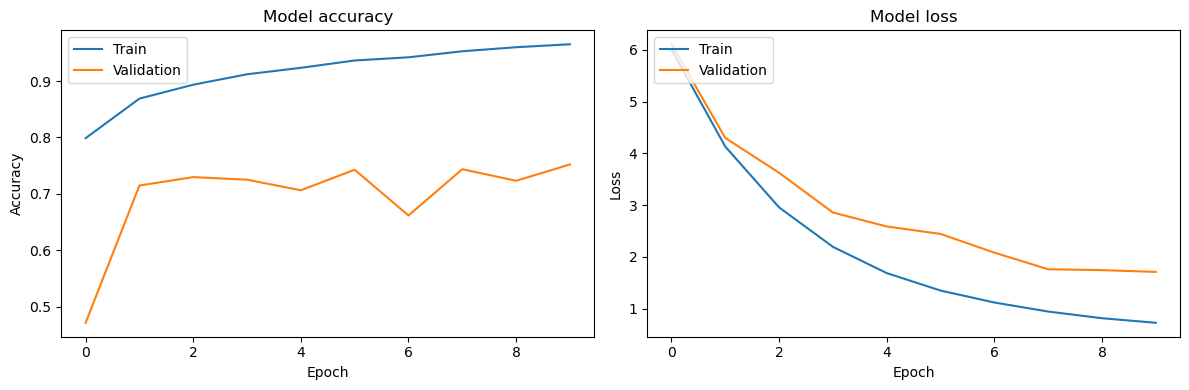

In [78]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
import librosa.display
import matplotlib.pyplot as plt

# Load the training data
independent = np.load('X_train.npy')
independent = independent.reshape(independent.shape[0], independent.shape[1], independent.shape[2], 1)
dependent = np.load('Y_train.npy')
dependent = pd.get_dummies(dependent).astype(int)

# Load the test data
independent_test = np.load('X_test.npy')
independent_test = independent_test.reshape(independent_test.shape[0], independent_test.shape[1], independent_test.shape[2], 1)
dependent_test = np.load('Y_test.npy')

# Split the test data into validation and test sets
independent_val, independent_test, dependent_val, dependent_test = train_test_split(
    independent_test, dependent_test, test_size=0.5, random_state=42)

# One-hot encode the validation and test labels
dependent_val = pd.get_dummies(dependent_val).astype(int)
dependent_test = pd.get_dummies(dependent_test).astype(int)

# Ensure all categories are included in one-hot encoding for both validation and test sets
dependent_categories = sorted(set(dependent_val.columns).union(set(dependent_test.columns)))
dependent_val = dependent_val.reindex(columns=dependent_categories, fill_value=0)
dependent_test = dependent_test.reindex(columns=dependent_categories, fill_value=0)

# Print shapes to verify
print(f'Training data shape: {independent.shape}, {dependent.shape}')
print(f'Validation data shape: {independent_val.shape}, {dependent_val.shape}')
print(f'Test data shape: {independent_test.shape}, {dependent_test.shape}')

# Define the model
X = tf.keras.layers.Input(shape=[128, 52, 1])
H = tf.keras.layers.Conv2D(32, kernel_size=3, activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01))(X)
H = tf.keras.layers.BatchNormalization()(H)
H = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(H)
H = tf.keras.layers.Conv2D(64, kernel_size=3, activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01))(H)
H = tf.keras.layers.BatchNormalization()(H)
H = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(H)
H = tf.keras.layers.Conv2D(128, kernel_size=3, activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01))(H)
H = tf.keras.layers.BatchNormalization()(H)
H = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(H)
H = tf.keras.layers.Flatten()(H)
H = tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(H)
H = tf.keras.layers.Dropout(0.5)(H)
Y = tf.keras.layers.Dense(len(dependent.columns), activation='softmax')(H)

model = tf.keras.models.Model(X, Y)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Train the model
history = model.fit(independent, dependent, epochs=10, validation_data=(independent_val, dependent_val), 
                    callbacks=[early_stopping, lr_scheduler])

# Evaluate the model on the test data
loss, accuracy = model.evaluate(independent_test, dependent_test)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


In [79]:
# Evaluate the model on the test data
loss, accuracy = model.evaluate(independent_test, dependent_test)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.7734 - loss: 1.5443
Test Loss: 1.7356889247894287
Test Accuracy: 0.7402234673500061


In [82]:
pred = model.predict(independent_test[1:30])
pd.DataFrame(pred).round(2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


,0,1,2,3,4,5,6
0,0.00,0.00,0.00,1.00,0.00,0.00,0.00
1,0.00,0.03,0.88,0.00,0.04,0.01,0.04
2,0.00,0.20,0.07,0.00,0.72,0.00,0.01
3,0.00,0.42,0.11,0.00,0.38,0.04,0.05
4,0.00,0.99,0.00,0.00,0.00,0.00,0.00
5,0.00,0.00,0.68,0.00,0.31,0.00,0.00
6,1.00,0.00,0.00,0.00,0.00,0.00,0.00
7,0.00,0.00,0.01,0.90,0.00,0.03,0.05
8,0.99,0.00,0.00,0.00,0.00,0.00,0.00
9,0.00,0.00,0.17,0.00,0.79,0.02,0.03


In [85]:
dependent_test['clap']

0       0
1       0
2       0
3       0
4       0
       ..
1069    1
1070    0
1071    0
1072    0
1073    1
Name: clap, Length: 1074, dtype: int64

In [84]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Make predictions
pred = model.predict(independent_test)
predicted_labels = np.argmax(pred, axis=1)
true_labels = np.argmax(dependent_test.values, axis=1)

# Generate a classification report
report = classification_report(true_labels, predicted_labels, target_names=dependent_test.columns)
print(report)

# Generate a confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
print(cm)

# Overall accuracy
overall_accuracy = accuracy_score(true_labels, predicted_labels)
print(f'Overall Accuracy: {overall_accuracy}')

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
              precision    recall  f1-score   support

        clap       0.94      0.95      0.95       252
       cough       0.65      0.75      0.70        65
      crying       0.63      0.78      0.69       163
    footstep       0.67      0.88      0.76       232
    laughter       0.74      0.62      0.67       236
      scream       0.81      0.30      0.43        84
      sneeze       0.42      0.12      0.19        42

    accuracy                           0.74      1074
   macro avg       0.69      0.63      0.63      1074
weighted avg       0.74      0.74      0.72      1074

[[240   1   0   9   1   0   1]
 [  1  49   3   0  10   0   2]
 [  3   1 127   5  23   2   2]
 [  9   4   2 203  12   2   0]
 [  1  16  58  12 146   2   1]
 [  0   1   8  48   1  25   1]
 [  0   3   5  24   5   0   5]]
Overall Accuracy: 0.7402234636871509
